Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray


Chapter 1: Exploring rasterio
==========================================

## Introduction

GDAL - the Geospatial Data Abstraction Library is a software library for reading and writing raster and vector geospatial data formats and forms the basis of most software for processing geospatial data.

There are many formats for using GDAL ranging from graphical tools like ArcGIS or QGIS to command line GDAL tools but here we're using the fantastic `rasterio` python package which provides a pythonic wrapping around GDAL. Basically it reads and writes geospatial formats and provides a Python API based on `numpy` N-dimensional arrays and GeoJSON.

If you're coming from another language and want an overview of object oriented programming in Python, see the [python like you meant it](https://pythonlikeyoumeanit.com) short online course.


## Module import in Python

Before we can get started, we need to tell Python that we will be using functions, classes, and variables from some packages. The technical wording for this is that we need to import these modules into our [namespace](http://en.wikipedia.org/wiki/Namespace) (see Python's documentation on the `module` system [here](https://docs.python.org/3/tutorial/modules.html)).

We will do this using some `import` statements:

In [1]:
import rasterio     # import the main rasterio function
import matplotlib   # matplotlib is the primary python plotting and viz library
# this bit of magic allows matplotlib to plot inline in a jupyter notebook
%matplotlib inline  

# We can check which version we're running by printing the "__version__" variable
print("rasterio's version is: " + rasterio.__version__)
print(rasterio)

rasterio's version is: 1.4.4
<module 'rasterio' from '/Users/emilysimeons/anaconda3/envs/edsml-rs/lib/python3.10/site-packages/rasterio/__init__.py'>


Once we import these packages Python will know where to look on our system for the code that implements them. When we want to access classes, variables, or functions within these packages, we will need to reference the full path (e.g. `rasterio.open()`)

### Examples
#### Open an image
When we open an image in rasterio we create a Dataset object. As the name would suggest, we can open an image with the "open" function within `rasterio`.

We will use an example image provided in the data directory for this chapter. This image is a subset of a Landsat 7 image containing the 8 bands on this sensor rearranged in order of wavelength (e.g., Landsat 7's second SWIR channel comes before thermal channel in our stack). The last band in this image is a cloud and cloud shadow mask from Fmask.

In [2]:
# filepath to our image
img_fp = '../data/LE70220492002106EDC00_stack.gtif'

# Open a geospatial dataset
dataset = rasterio.open(img_fp)
print(dataset)

<open DatasetReader name='../data/LE70220492002106EDC00_stack.gtif' mode='r'>


Now that we have this dataset open, let's explore some of its capabilities.

### Image attributes

In [3]:
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ../data/LE70220492002106EDC00_stack.gtif

Number of bands in image: 8

Image size is: 250 rows x 250 columns

Raster description: ('band 1 reflectance', 'band 2 reflectance', 'band 3 reflectance', 'band 4 reflectance', 'band 5 reflectance', 'band 7 reflectance', 'band 6 temperature', 'Band 8')

Raster driver: GTiff

Image projection:
EPSG:32615 

Image geo-transform:
| 30.00, 0.00, 462405.00|
| 0.00,-30.00, 1741815.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 250, 'height': 250, 'count': 8, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["sc

The first few pieces of information we obtained are fairly straightforward - image name, the raster size, the number of bands, a description, some metadata, and the raster's file format.

The image's projection is formatted in what's known as "Well Known Text". For more information on specific projections and for format conversions among projection description formats (e.g., proj4 string, WKT, ESRI WKT, JSON, etc.) see [Spatial Reference](http://www.spatialreference.org).

The last piece of information we accessed is something called a "geotransform". This set of 6 numbers provides all the information required to and from transform pixel and projected coordinates. In this example, the first number (462405) and the fourth number (1741815) are the top left of the upper left pixel of the raster. The pixel size in x and y dimensions of the raster is listed as the second (30) and the sixth (-30) numbers. Since our raster is north up oriented, the third and fifth numbers are 0. For more information on the GDAL data model, [visit this web page](https://gdal.org/user/raster_data_model.html).

### Image raster bands

##### now for the fun part, actually visualizing and working with the data

The rasterio Dataset object we created contains a lot of useful information but it is not directly used to read in the raster image. Instead we will need to access the raster's bands using the `read()` method:

In [4]:
# Open the fourth band in our image - NIR here
nir = dataset.read(4)
nir.shape # check out the dimensions of the image

(250, 250)

When we load our raster band into memory we will read it into a [NumPy](http://www.numpy.org/) 2 dimensional array. NumPy is, ["the fundamental package for scientific computing with Python"](http://www.numpy.org/), because it allows us to represent our data in a very memory efficient way.

NumPy arrays are the cornerstone or building block of the rest of the Scientific Python suite of software. Get familiar with them:

+ [NumPy for MATLAB users](http://wiki.scipy.org/NumPy_for_Matlab_Users)
+ [NumPy tutorial](http://wiki.scipy.org/Tentative_NumPy_Tutorial)
+ [NumPy API reference manual](http://docs.scipy.org/doc/numpy/reference/)

Just as we made the routines and data types from rasterio available to us using `import`, we loaded up NumPy. When we import NumPy, we also gave it an alias so that we don't have to type `numpy` every time we want to use it.

In [5]:
# No alias
import numpy
print(numpy.__version__)

# Alias or rename to "np" -- a very common practice
import numpy as np
print(np.__version__)

2.2.6
2.2.6


In [6]:
# What are the band's datatypes?
datatype = dataset.dtypes
print('Band datatypes: {dt}'.format(dt=datatype))

# How about some band statistics?
band_mean = np.mean(nir)
band_min = np.amin(nir)
band_max = np.amax(nir)
band_stddev = np.std(nir)
print('Band range: {minimum} - {maximum}'.format(maximum=band_max,
                                                 minimum=band_min))
print('Band mean, stddev: {m}, {s}\n'.format(m=band_mean, s=band_stddev))

Band datatypes: ('int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16')
Band range: 1007 - 8178
Band mean, stddev: 2700.18344, 710.1296021415855



The method `read()` takes arguments that allow us to specify a subset of the raster bands, specific X and Y offsets and sizes of the bands and much more. Remember this ability when you want to process large images or are working with a limited amount of memory. In these circumstances, you will run out of memory if you read the entire dataset in at once. Instead, read in a block of some number of columns and rows at one time, perform your computation and store your output, and then chunk through the rest of the image.

Read more here: https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.BufferedDatasetWriter.read

For now, because this image is small, we'll just read in and display the entire image:

In [7]:
full_img = dataset.read()
full_img.shape # bands, rows, cols

(8, 250, 250)

With our data read into a NumPy array, we can print it to console and even perform statistics on it. In addition to helping us store massive amounts of data efficiently, NumPy will help us with some basic linear algebra, numerical operations, and summary statistics.

For now let's plot that near infrared band we read in earlier.

Image dimensions:  (8, 250, 250)


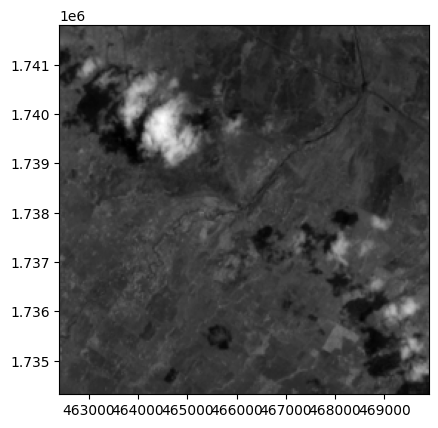

<Axes: >

In [8]:
from rasterio.plot import show # import the show function which allows us to display the image

print("Image dimensions: ", full_img.shape)
show(nir, transform=dataset.transform, cmap='gray')

The next chapter (link to [webpage](chapter_2_indices.html) or [Notebook](chapter_2_indices.ipynb)) puts these lessons to use in order to calculate the Normalized Difference Vegetation Index (NDVI).